# Hands On #9

**RNNs, Attention, and Transformers**

File name convention: For group 42 and memebers Richard Stallman and Linus <br>
Torvalds it would be <br>
"09_group42_Stallman_Torvalds.pdf".

Submission via blackboard (UA).

Feel free to answer free text questions in text cells using markdown and <br>
possibly $\LaTeX{}$ if you want to.

**You don't have to understand every line of code here and it is not intended <br>
for you to try to understand every line of code.   <br>
Big blocks of code are usually meant to just be clicked through.**

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision

import numpy as np
import os

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading and Preparing the Dataset

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [4]:
np.random.seed(42)

n_steps = 50
total_samples = 100_000
series = generate_time_series(total_samples, n_steps + 1)

# Split the dataset:
X_train, y_train = series[:80_000, :n_steps], series[:80_000, -1]
X_valid, y_valid = series[80_000:90_000, :n_steps], series[80_000:90_000, -1]
X_test, y_test   = series[90_000:, :n_steps], series[90_000:, -1]

In [5]:
X_train.shape, y_train.shape

((80000, 50, 1), (80000, 1))

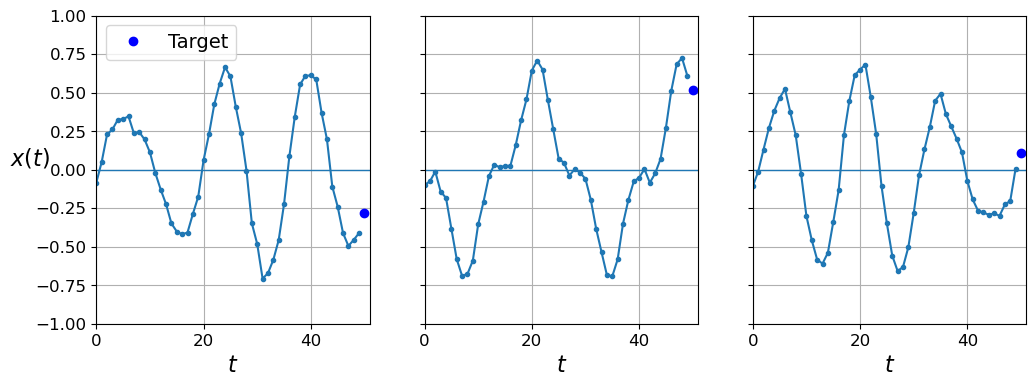

In [6]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

In [7]:
class TimeSeries(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.copy()).float()
        self.y = torch.from_numpy(y.copy()).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = TimeSeries(X_train, y_train)
valid_data = TimeSeries(X_valid, y_valid)
test_data = TimeSeries(X_test, y_test)

batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

In [8]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None, device='cpu'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    model.to(device)  # Move the model to the specified device

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            y = y
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                epoch_metric += metric(outputs, y)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                y_val = y_val
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                if metric is not None:
                    val_metric += metric(outputs_val, y_val)
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        if scheduler is not None:
            scheduler.step()

    return history, model

In [9]:
def test_model(model, data_loader, criterion, metric=None, device='cpu'):
    model.to(device)  # Move the model to the specified device

    model.eval()  # Set the model to evaluation mode

    total_loss = 0.0  # Initialize the total loss and metric values
    total_metric = 0.0


    with torch.no_grad():  # Disable gradient tracking
        for batch in data_loader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            # Pass the data to the model and make predictions
            outputs = model(X)

            # Compute the loss
            loss = criterion(outputs, y)

            # Add the loss and metric for the batch to the total values
            total_loss += loss.item()

            if metric is not None:
                total_metric += metric(outputs, y)
            else:
                total_metric += 0.0

    # Average loss and metric for the entire dataset
    avg_loss = total_loss / len(data_loader)
    avg_metric = total_metric / len(data_loader)

    print(f'Test Loss: {avg_loss:.4f}, Test Metric: {avg_metric:.4f}')

    return avg_loss, avg_metric

# Recurrent Neural Networks

# The Simple Recurrent Neural Network RNN

The simplest form of **RNN** one can build **takes an output and passes it into the** <br>
**next input**. The idea is that, if your data has some form of **sequential** property <br>
such as being elements of a **time series** or a sentence or even generally related <br>
(not explicitly sequential) values, you should attempt to **inform your model via** <br>
**explicit neural connections** that those values are linked. By passing the output <br>
of one neuron to the next neuron in a sequence, you can explicitly inform your <br>
model of the relationship of an input to its neighboring inputs.

## Task 1: Simple RNN

Build  a simple RNN using the `SimpleRNN` module. Your model should be a <br>
Sequential model called `simplernn` of the following form:<br>
`input_size=1, hidden_size=16, output_size=1, seq_len=50`

Train the model using the train_and_validate function on train_loader and <br>
valid_loader using MSELoss as criterion, L1Loss as metric, and the Adam <br>
optimizer with lr=0.001. Train for 6 epochs.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [26]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_len):
        super(SimpleRNN, self).__init__()
        self.rnn1 = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * seq_len, output_size)
    def forward(self, x):
        x, hn = self.rnn1(x)
        x, _ = self.rnn2(x, hn)
        x = x.reshape(-1, x.size(1) * x.size(2))
        x = self.fc(x)
        return x

In [27]:
simplernn = SimpleRNN(input_size = 1, hidden_size = 16, output_size = 1, seq_len = 50)
criterion = nn.MSELoss()
metric = nn.L1Loss()
optimizer = torch.optim.Adam(simplernn.parameters(), lr = 0.001)

history, simplernn = train_and_validate(train_loader = train_loader,
                                        val_loader = valid_loader, 
                                        model = simplernn, 
                                        optimizer = optimizer, 
                                        criterion = criterion, 
                                        num_epochs = 6,
                                        metric = metric)


Epoch [1/6], Train Loss: 0.0046, Train Metric: 0.0506, Val Loss: 0.0032, Val Metric: 0.0457
Epoch [2/6], Train Loss: 0.0032, Train Metric: 0.0459, Val Loss: 0.0030, Val Metric: 0.0444
Epoch [3/6], Train Loss: 0.0032, Train Metric: 0.0455, Val Loss: 0.0036, Val Metric: 0.0482
Epoch [4/6], Train Loss: 0.0031, Train Metric: 0.0452, Val Loss: 0.0031, Val Metric: 0.0447
Epoch [5/6], Train Loss: 0.0031, Train Metric: 0.0450, Val Loss: 0.0030, Val Metric: 0.0446
Epoch [6/6], Train Loss: 0.0031, Train Metric: 0.0449, Val Loss: 0.0031, Val Metric: 0.0448


↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above this

In [28]:
test_model(simplernn, test_loader, criterion, metric=metric, device=device)

Test Loss: 0.0030, Test Metric: 0.0446


(0.00303845506004146, tensor(0.0446))

In [29]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 10, 0.002, 0.01])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

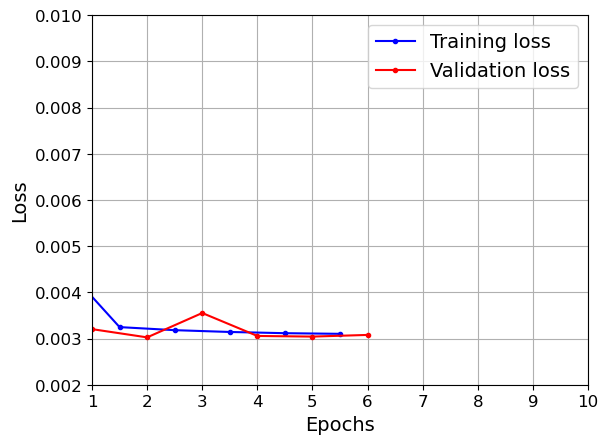

In [30]:
plot_learning_curves(history["train_loss"], history["val_loss"])
plt.show()

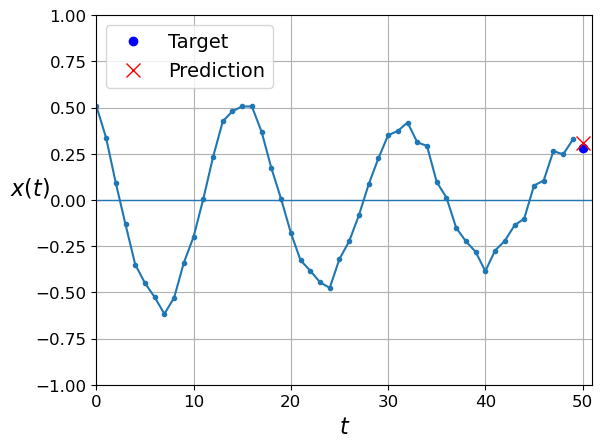

In [31]:
y_pred = simplernn(torch.from_numpy(X_test).to(device)).to('cpu').detach().numpy()
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

In [32]:
print(y_pred.shape)

(10000, 1)


In [10]:
np.random.seed(43) # not 42, as it would give the first series in the train set

new_series = generate_time_series(1, n_steps + 10)
X_new, Y_new = new_series[:, :n_steps], new_series[:, n_steps:]

In [34]:
X = X_new
for step_ahead in range(10):
    y_pred_one = simplernn(torch.from_numpy(X[:, step_ahead:]).to(device)).to('cpu').detach().numpy()[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred_new = X[:, n_steps:]

In [35]:
y_pred_new.shape

(1, 10, 1)

In [16]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

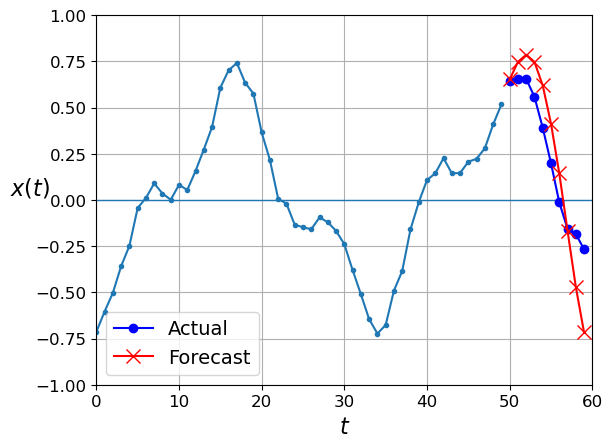

In [37]:
plot_multiple_forecasts(X_new, Y_new, y_pred_new)
plt.show()

# The Gated Recurrent Unit (GRU)

GRU models are **actually very new** in the timeline of RNNs having been first <br>
**proposed in 2014** by Kyunghyun Cho et al. The main feature that this adds to the <br>
RNN architechture is that it replaces the simple densely connected unit with a <br>
new unit that adds a **"forget gate"**. You might remember the **characteristic** <br>
**equation for a standard neuron** is $a_i=\sigma(w_ix_i + b_l)$. For the GRU you add <br>
a term which depends on a new weight we can call u which is applied to the <br>
output of the previous neuron: $a_i=\sigma(w_ix_i + u_ih_{i-1} + b_l)$ where h is the final <br>
output of the previous neuron. Additionally, it takes that initial activation and <br>
applies two steps:<br>
1) $\hat h_i=\phi(w_{2i}x_i+u_{2i}(a_i\odot h_{i-1}) + b_{2l})$ where $\phi$ is tanh and $w_2$ is a second <br>
neuron weight meaning that the simplest **GRU will have 4 weights and 2 biases**.<br>
2) $h_i=(1-a_i)\odot h_{i-1}+a_i\odot \hat h_i$)

If we consider what those equations mean then you can probably work out that <br>
**(1), our forget gate**, is checking how correlated our activation is with our <br>
previous neuron's activation. Then, **if our output is highly correlated**, our <br>
final activation **(2) will have a large contribution from our previous neuron** <br>
and if uncorrelated, it will have a small contribution.

The modern standard implementation of GRU also now includes a "reset gate" and <br>
an "update gate" which you can read about further [here](https://en.wikipedia.org/wiki/Gated_recurrent_unit).

## Task 2: Simple GRU Model

Build an identical model to task 1 but substituting `GRU` layers instead of <br>
`RNN` layers and instead call the model `simplegru`. The model and training <br>
should be otherwise identical to the training from above. Be sure to pass <br>
simplegru's parameters to the optimizer and not simplernn's parameters.

https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [22]:
# class SimpleGRU(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, seq_len):
#         super(SimpleGRU, self).__init__()
#         self.gru1 = nn.GRU(input_size, hidden_size, batch_first = True)
#         self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first = True)
#         self.fc = nn.Linear(hidden_size * seq_len, output_size)
#     def forward(self, x):
#         x, hn = self.gru1(x)
#         x, _ = self.gru2(x, hn)
#         x = x.reshape(-1, x.size(1) * x.size(2))
#         x = self.fc(x)
#         return x

In [23]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_len):
        super(SimpleGRU, self).__init__()
        self.rnn1 = nn.GRU(input_size, hidden_size, batch_first=True)
        self.rnn2 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * seq_len, output_size)
    def forward(self, x):
        x, hn = self.rnn1(x)
        x, _ = self.rnn2(x, hn)
        x = x.reshape(-1, x.size(1) * x.size(2))
        x = self.fc(x)
        return x

In [ ]:
simplegru = SimpleGRU(input_size = 1, hidden_size = 16, output_size = 1, seq_len = 50)
criterion = nn.MSELoss()
metric = nn.L1Loss()
optimizer = torch.optim.Adam(simplegru.parameters(), lr = 0.001)

history, simplernn = train_and_validate(train_loader = train_loader,
                                        val_loader = valid_loader, 
                                        model = simplegru, 
                                        optimizer = optimizer, 
                                        criterion = criterion, 
                                        num_epochs = 6,
                                        metric = metric)

Epoch [1/6], Train Loss: 0.0055, Train Metric: 0.0536, Val Loss: 0.0033, Val Metric: 0.0466
Epoch [2/6], Train Loss: 0.0033, Train Metric: 0.0460, Val Loss: 0.0031, Val Metric: 0.0449
Epoch [3/6], Train Loss: 0.0032, Train Metric: 0.0455, Val Loss: 0.0033, Val Metric: 0.0464
Epoch [4/6], Train Loss: 0.0031, Train Metric: 0.0452, Val Loss: 0.0031, Val Metric: 0.0453
Epoch [5/6], Train Loss: 0.0031, Train Metric: 0.0450, Val Loss: 0.0032, Val Metric: 0.0457


↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above this

In [ ]:
test_model(simplegru, test_loader, criterion, metric=metric, device=device)

In [ ]:
X = X_new
for step_ahead in range(10):
    y_pred_one = simplegru(torch.from_numpy(X[:, step_ahead:]).to(device)).to('cpu').detach().numpy()[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred_new = X[:, n_steps:]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, y_pred_new)
plt.show()

# The Long Short-Term Memory (LSTM)

LSTM's were among the state of the art for language processing tasks for quite <br>
some time. Interestingly though, they were **first proposed in 1995** by Hochreiter <br>
and Schmidhuber almost **20 years before GRU**. In fact, LSTM models **outperform** <br>
**GRU models** on many tasks and by many metrics. However, **not without costs**. LSTM <br>
cells require **more storage space** and are **slower** than GRU cells. This is due to <br>
the fact that they have an additional **"long-term memory"** value which they can <br>
use to preserve information even between iterations. Whereas GRU will only <br>
"remember" information passed by adjacent neurons, **LSTM will remember** that and <br>
also information passed by **previous batches or iterations of data**.

# Task 3: Long Short-Term Memory (LSTM) Model

Build an identical model to task 1 but substituting `LSTM` layers instead of <br>
`RNN` layers and instead call the model `simplelstm`. The model and training <br>
should be otherwise identical to the training from above. Be sure to pass <br>
simplelstm's parameters to the optimizer and not simplernn's parameters.

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [ ]:
# class SimpleLSTM(

In [38]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_len):
        super(SimpleLSTM, self).__init__()
        self.rnn1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * seq_len, output_size)
    def forward(self, x):
        x, hn = self.rnn1(x)
        x, _ = self.rnn2(x, hn)
        x = x.reshape(-1, x.size(1) * x.size(2))
        x = self.fc(x)
        return x

In [39]:
simplelstm = SimpleLSTM(input_size = 1, hidden_size = 16, output_size = 1, seq_len = 50)
criterion = nn.MSELoss()
metric = nn.L1Loss()
optimizer = torch.optim.Adam(simplelstm.parameters(), lr = 0.001)

history, simplernn = train_and_validate(train_loader = train_loader,
                                        val_loader = valid_loader, 
                                        model = simplelstm, 
                                        optimizer = optimizer, 
                                        criterion = criterion, 
                                        num_epochs = 6,
                                        metric = metric)

Epoch [1/6], Train Loss: 0.0063, Train Metric: 0.0560, Val Loss: 0.0036, Val Metric: 0.0483
Epoch [2/6], Train Loss: 0.0032, Train Metric: 0.0459, Val Loss: 0.0032, Val Metric: 0.0459
Epoch [3/6], Train Loss: 0.0031, Train Metric: 0.0450, Val Loss: 0.0034, Val Metric: 0.0471
Epoch [4/6], Train Loss: 0.0030, Train Metric: 0.0438, Val Loss: 0.0030, Val Metric: 0.0441
Epoch [5/6], Train Loss: 0.0027, Train Metric: 0.0417, Val Loss: 0.0024, Val Metric: 0.0400
Epoch [6/6], Train Loss: 0.0024, Train Metric: 0.0399, Val Loss: 0.0024, Val Metric: 0.0395


↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above this

In [40]:
test_model(simplelstm, test_loader, criterion, metric=metric, device=device)

Test Loss: 0.0024, Test Metric: 0.0393


(0.002366866066587464, tensor(0.0393))

In [41]:
X = X_new
for step_ahead in range(10):
    y_pred_one = simplelstm(torch.from_numpy(X[:, step_ahead:]).to(device)).to('cpu').detach().numpy()[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred_new = X[:, n_steps:]

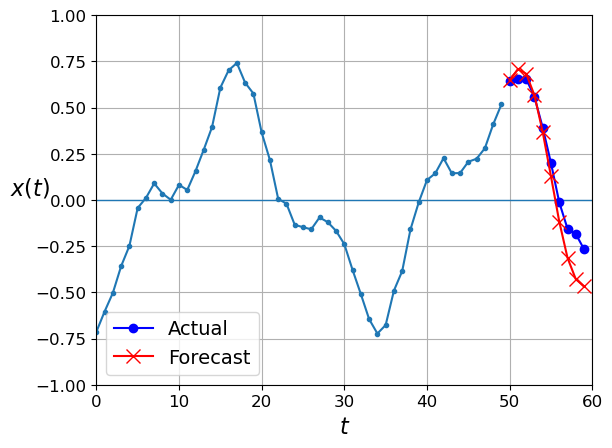

In [42]:
plot_multiple_forecasts(X_new, Y_new, y_pred_new)
plt.show()

## Task 3: Analyzing Model Performance

Question: Compare the behavior of LSTM to GRU and simple RNN. Which region of <br>
future forecasting is most different? Describe characteristics about the <br>
various models that would lead to that difference.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 3) answer:

Can't really compare GRU, but if i had to guess: \
short predictions: RNN, GRU, LSTM \
mid predictions: GRU, LSTM \
far predictions: LSTM

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above this

# The Luong Attention Mechanism

Attention is an operation built around applying a **dot product** across **1) outputs** <br>
**from the head of a model** which has "encoded" the data by transforming with <br>
weights and biases and **2) hidden states (weights) from the tail of a model** <br>
which is attempting to "decode" the data and turn it into your desired output.

That is a long sentence but what it breaks down to is that you're **reweighting** <br>
**data** part way through a model so that the back half of your model knows what's <br>
most important from what the first half did. When Luong, Pham and Manning <br>
published [this paper](https://arxiv.org/abs/1508.04025) in 2015, they achieved
**state of the art results** and laid the <br>
foundation for the **Third Wave of AI** driven largely by attention-based <br>
Transformer models.

In [11]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_len):
        super(AttentionLSTM, self).__init__()
        self.seq_len = seq_len

        # Encoder LSTM: processes the input sequence.
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Decoder LSTM: will receive the original input concatenated with the context.
        # Since we concatenate the context (of size hidden_size) with the original input,
        # the decoder input dimension becomes input_size + hidden_size.
        self.decoder = nn.LSTM(input_size + hidden_size, hidden_size, batch_first=True)

        # Final fully connected layer to map flattened decoder outputs to the desired output size.
        self.fc = nn.Linear(hidden_size * seq_len, output_size)

        # Softmax applied over the sequence dimension.
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        # ----------------------------
        # Encoder: process the input sequence.
        encoder_outputs, (h_enc, c_enc) = self.encoder(x)
        # encoder_outputs shape: (batch, seq_len, hidden_size)
        # h_enc shape: (num_layers, batch, hidden_size)

        # ----------------------------
        # Attention: Compute Luong-style dot-product attention.
        # Use the final encoder hidden state as the query.
        query = h_enc[-1]  # shape: (batch, hidden_size)

        # To compute dot products between the query and each time step in encoder_outputs:
        # Expand query to shape (batch, hidden_size, 1)
        query = query.unsqueeze(2)
        # Compute scores: dot product between each encoder output and the query.
        # encoder_outputs: (batch, seq_len, hidden_size)
        # Resulting scores shape: (batch, seq_len, 1) -> squeeze to (batch, seq_len)
        scores = torch.bmm(encoder_outputs, query).squeeze(2)

        # Normalize the scores with softmax to get attention weights.
        attn_weights = self.softmax(scores)  # shape: (batch, seq_len)

        # Compute the context vector as a weighted sum of encoder outputs.
        # attn_weights unsqueezed to shape (batch, 1, seq_len) for bmm.
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        # context shape: (batch, hidden_size)

        # Decoder: Incorporate the context into the decoder input.
        # Here we repeat the context vector along the time dimension and concatenate it with x.
        context_repeated = context.unsqueeze(1).repeat(1, self.seq_len, 1)  # shape: (batch, seq_len, hidden_size)
        decoder_input = torch.cat((x, context_repeated), dim=2)  # shape: (batch, seq_len, input_size + hidden_size)

        decoder_outputs, _ = self.decoder(decoder_input)

        # decoder_outputs shape: (batch, seq_len, hidden_size)
        decoder_outputs = decoder_outputs.reshape(decoder_outputs.size(0), -1)
        out = self.fc(decoder_outputs)
        return out

In [12]:
attlstm = AttentionLSTM(1, 16, 1, 50)
criterion = nn.MSELoss()
metric = nn.L1Loss()
optimizer = torch.optim.Adam(attlstm.parameters(), lr=0.001)
history, attlstm = train_and_validate(train_loader, valid_loader, attlstm, optimizer, criterion, num_epochs=6, metric=metric, scheduler=None, device=device)

Epoch [1/6], Train Loss: 0.0066, Train Metric: 0.0567, Val Loss: 0.0032, Val Metric: 0.0459
Epoch [2/6], Train Loss: 0.0031, Train Metric: 0.0452, Val Loss: 0.0031, Val Metric: 0.0450
Epoch [3/6], Train Loss: 0.0030, Train Metric: 0.0440, Val Loss: 0.0028, Val Metric: 0.0424
Epoch [4/6], Train Loss: 0.0028, Train Metric: 0.0431, Val Loss: 0.0028, Val Metric: 0.0424
Epoch [5/6], Train Loss: 0.0028, Train Metric: 0.0424, Val Loss: 0.0027, Val Metric: 0.0418
Epoch [6/6], Train Loss: 0.0027, Train Metric: 0.0419, Val Loss: 0.0026, Val Metric: 0.0416


In [13]:
test_model(attlstm, test_loader, criterion, metric=metric, device=device)

Test Loss: 0.0026, Test Metric: 0.0410


(0.0025659927835954013, tensor(0.0410))

In [14]:
X = X_new
for step_ahead in range(10):
    y_pred_one = attlstm(torch.from_numpy(X[:, step_ahead:]).to(device)).to('cpu').detach().numpy()[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred_new = X[:, n_steps:]

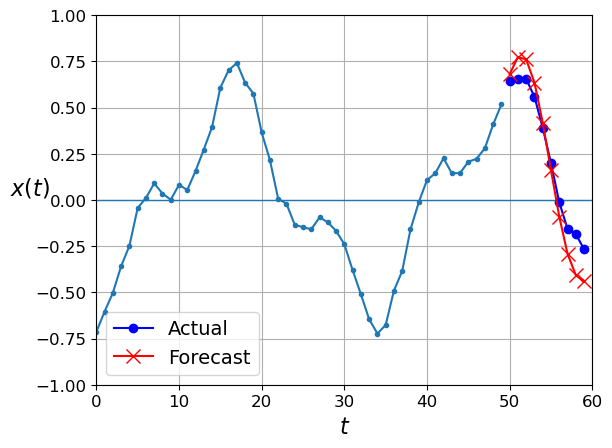

In [17]:
plot_multiple_forecasts(X_new, Y_new, y_pred_new)
plt.show()

# The Transformer Model

The transformer architecture was first proposed in a paper called <br>
[Attention is All You Need (Vaswani et. al 2017](https://arxiv.org/abs/1706.03762).

The characteristic operation of the transformer is the **self-attention** <br>
operation. In essence, it is using **dot product** operations along different axes <br>
of the data to amplify the importance of relevant data. You can think of this <br>
as effectively building **a model that reweights its inputs** to pick out the most <br>
important and relevant inputs. Then it does typical mathematical operations of <br>
**densely connected layers** on those reweighted inputs.

Researchers figured out several years before this that dot-product attention <br>
could be used in combination with other forms of models to improve performance <br>
by reweighting input data but the **Attention is All You Need** paper showed that, <br>
as the name would imply, you can get even **better performance** by eliminating all <br>
other characteristic layers and instead **using only attention and dense layers**.

In [18]:
print(X_train.shape)

(80000, 50, 1)


## Task 5: Definining model dimensions

Define two variables: <br>
1) `max_len` should be equal to the size of the dimension from X_train that <br>
describes the length of the time series. **Hint: see above plots**<br>
2) `embedding_dim` should be equal to the fourth root (**(1/4)) of the total <br>
number of unique datapoints (e.g. number of samples * time series length).

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [23]:
# max_len = X_train.shape[1]  # = 50
# # Note: embedding_dim must be an even number
# embedding_dim = (80000*50)**0.25
# print(max_len)
# print(embedding_dim)

n_samples, max_len, n_features = X_train.shape

# 1) Time-series length
max_len = max_len  # 50

# 2) Embedding dimension: fourth root of (n_samples * max_len)
total_datapoints = n_samples * max_len            # 80000 * 50 = 4_000_000
raw_dim          = total_datapoints ** 0.25       # ≈ 44.72
# Convert to int and ensure it's even:
embedding_dim = int(raw_dim)
if embedding_dim % 2 != 0:
    embedding_dim += 1

print("max_len      =", max_len)        # 50
print("embedding_dim =", embedding_dim)  # 44


max_len      = 50
embedding_dim = 44


↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above this

It's typical with transformers to embed our inputs into a higher dimensional <br>
space. For discrete data such as integers or words, it's typical to use an  <br>
embedding layer from the pytorch toolkit. However, for continuous data, it's <br>
more common to embed using linear or non-linear transformations.

In [25]:
class LinearEmbedding(nn.Module):
  def __init__(self, in_features, out_features, **kwargs):
    super().__init__(**kwargs)
    self.linear = nn.Linear(in_features=in_features, out_features=out_features)
  def forward(self, x):
    return self.linear(x)

Another interesting feature of transformers is that they are not explicitly <br>
aware of the order of data in a relative sequence, especially after embedding. <br>
We therefore can inform it of positions by, for example, adding a small amount <br>
related to its position in the tensor by some interpretable form like periodic <br>
functions.

In [26]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=512):
        super(SinusoidalPositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        #Note: The value of 100.0 below corresponds to an encoding wavelength.
        #For LLMs this is often set much larger to, say 10k or ~10x the embed dim
        #The value of 100.0 was designed for very low-dimensional embedding data.
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-torch.log(torch.tensor(100.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        batch_size, seq_len, d_model = x.size()
        pe = self.pe[:, :seq_len, :]
        pe = pe.expand(batch_size, -1, -1)
        x = x + pe / torch.norm(pe, p=2, dim=-1, keepdim=True)
        return x

Transformer models use **multi-head attention (MHA)** which is very similar <br>
to the attention we saw before with LSTM. Here, we treat our data as having <br>
the three dimensions **(batch_size, sequence_length, features)**. We use the <br>
linear embedding layer we saw before to **add additional information** to the <br>
features dimension in our data. In transformer notation, typically data is <br>
expressed as having the dimensions **(q,k,v)** or **(query, key value)**. That means <br>
each item in the **batch is a query** that try get get information for. We use <br>
the dot product operation for that query item with the other **keys and values** <br>
or **sequences and features** in the data and then add that information back to <br>
the query and then normalize to avoid exploding values.

<br>

**Short summary:**<br>
What this means is that at their core, transformers use dot product attention <br>
to **extract additional information** about how items in the sequence are **related** <br>
to one another, **add that information** to the original data, and then pass <br>
the modified data to a dense neural network.

In [28]:
class NextTokenPredictionTransformer(nn.Module):
        def __init__(self, embed_dim, latent_dim, num_heads, num_encoders, num_decoders, dropout, sequence_length, device):
            super(NextTokenPredictionTransformer, self).__init__()
            self.seq_len = sequence_length
            self.trans = nn.Transformer(d_model=embed_dim, nhead=num_heads,
                                        num_encoder_layers=num_encoders, num_decoder_layers=num_decoders,
                                        dim_feedforward=latent_dim, dropout=dropout, batch_first=True)
            self.sinemb = SinusoidalPositionalEncoding(embed_dim, sequence_length)
            self.linemb = LinearEmbedding(1, embed_dim)
            self.lin1 = nn.Linear(embed_dim, latent_dim)
            self.relu = nn.ReLU()
            self.lin2 = nn.Linear(latent_dim, 1)

        def forward(self, src, tgt):
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = self.create_mask(src, tgt)
            src_padding_mask = src_padding_mask.squeeze(-1)
            tgt_padding_mask = tgt_padding_mask.squeeze(-1)
            src = self.linemb(src)
            tgt = self.linemb(tgt)
            src = self.sinemb(src)
            tgt = self.sinemb(tgt)
            out = self.trans(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask,
                             src_key_padding_mask=src_padding_mask,
                             tgt_key_padding_mask=tgt_padding_mask)
            output = self.lin1(out)
            output = self.relu(output)
            output = self.lin2(output)
            return output


        def generate_square_subsequent_mask(self, sz, device):
            mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
            mask = ~mask
            return mask

        def create_mask(self, src, tgt):
            src_seq_len = src.shape[1]
            tgt_seq_len = tgt.shape[1]

            tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len, device)
            src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

            src_padding_mask = (src == 0)
            tgt_padding_mask = (tgt == 0)
            return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

**Note: Transformers are often much larger in dimensionality than RNNs so we may** <br>
**need to use different training procedure like schedules for best results.**

In [29]:
def transformer_train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None, device='cpu'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    model.to(device)  # Move the model to the specified device

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device).unsqueeze(-1)
            optimizer.zero_grad()  # Clear existing gradients
            y_input = torch.cat((X[:, 1:], y[:, -1:]), dim=1)
            outputs = model(X[:,1:], y_input[:,:-1])
            # Reshape outputs and targets to match the shape expected by the loss function
            outputs = outputs.view(-1)
            y_input = y_input[:,1:].contiguous().view(-1)
            loss = criterion(outputs, y_input)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()

            epoch_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                epoch_metric += metric(outputs, y_input)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device).unsqueeze(-1)
                y_input = torch.cat((X_val[:, 1:], y_val[:, -1:]), dim=1)
                outputs_val = model(X_val[:, 1:], y_input[:,:-1])
                outputs_val = outputs_val.view(-1)
                y_input = y_input[:,1:].contiguous().view(-1)
                val_loss += criterion(outputs_val, y_input).item()
                if metric is not None:
                    val_metric += metric(outputs_val, y_input).item()
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        if scheduler is not None:
            scheduler.step()

    return history, model

## Task 6: Build a train a NextTokenPredictionTransformer

The transformer parameters should be:<br>
`embed_dim` = embedding_dim<br>
`latent_dim` = 16<br>
`num_heads` = 1<br>
`num_encoders` = 1<br>
`num_decoders` = 1<br>
`dropout` = 0.0<br>
`sequence_length` = max_len<br>

Transformers are a bit less stable to train so we'll need to use a slightly <br>
more complicated training procedure.

Use Adam optimizer with `lr=0.001` and train for 6 epochs using MSELoss as <br>
your criterion and L1Loss as your metric.

In [34]:
torch.manual_seed(42)
transformer = NextTokenPredictionTransformer(
    embed_dim = embedding_dim,
    latent_dim = 16,
    num_heads = 1,
    num_encoders = 1,
    num_decoders = 1,
    dropout = 0.0,
    sequence_length = max_len,
    device = 'cpu'
)

criterion = nn.MSELoss()
metric = nn.L1Loss()
optimizer = torch.optim.Adam(transformer.parameters(), lr = 0.001)
history, transformer = transformer_train_and_validate(
    train_loader = train_loader,
    val_loader = valid_loader,
    model = transformer,
    optimizer = optimizer,
    criterion = criterion,
    num_epochs = 6,
    metric = metric,
    device = 'cpu'
)

Epoch [1/6], Train Loss: 0.0026, Train Metric: 0.0326, Val Loss: 0.0002, Val Metric: 0.0074
Epoch [2/6], Train Loss: 0.0002, Train Metric: 0.0061, Val Loss: 0.0001, Val Metric: 0.0036
Epoch [3/6], Train Loss: 0.0001, Train Metric: 0.0046, Val Loss: 0.0001, Val Metric: 0.0067
Epoch [4/6], Train Loss: 0.0001, Train Metric: 0.0040, Val Loss: 0.0001, Val Metric: 0.0025
Epoch [5/6], Train Loss: 0.0001, Train Metric: 0.0034, Val Loss: 0.0001, Val Metric: 0.0023
Epoch [6/6], Train Loss: 0.0001, Train Metric: 0.0034, Val Loss: 0.0001, Val Metric: 0.0040


In [35]:
def generate_next_step(model, input_sequence):
    model.eval()
    with torch.no_grad():
        input_sequence = input_sequence.to(device)
        output = model(input_sequence[:, 1:], input_sequence[:, :-1])
        next_token_prediction = output[:, -1, :]
    return next_token_prediction

In [36]:
X = X_new
for step_ahead in range(10):
    y_pred_one = generate_next_step(transformer, torch.from_numpy(X[:, step_ahead:]).to(device)).to('cpu').detach().numpy()[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred_new = X[:, n_steps:]

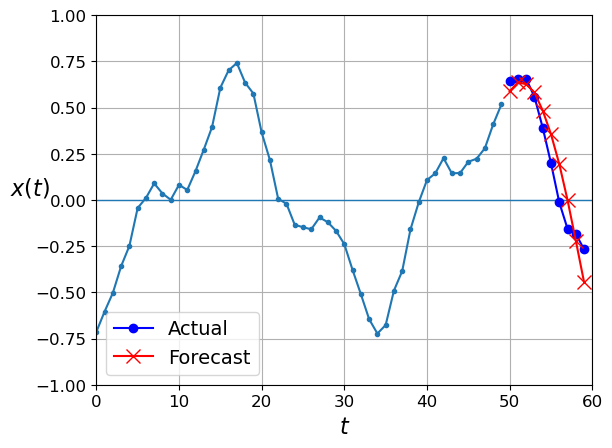

In [37]:
plot_multiple_forecasts(X_new, Y_new, y_pred_new)
plt.show()

## Task 7 (Bonus): Model performance analysis

Analyze the performance of at least 3 models used in previous tasks using at <br>
least two different metrics on the test data sets or newly generated data. <br>
Examples of metrics might be single-event prediction error, forecasting error, <br>
or deviation-based metrics.

Further, provide a brief text description (less than 500 words) explaining the <br>
metric used and results.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

Task 7) answer:

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above this

## ChatGPT

GPT stands for **"generative, pre-trained transformer"**. ChatGPT is a version of <br>
a gpt **created by OpenAI** which made waves in late 2022 because of how well it <br>
mimics human conversation and interaction. Below, we'll look at how to access <br>
**ChatGPT in colab using a public API**. It is not possible to house the full model <br>
in a typical colab notebook because the model has an astounding **175 billion** <br>
**model parameters**. For comparison, two fully connected dense layers with 10,000 <br>
neurons each would only have around 100 million parameters.

In March 2023, OpenAI also released GPT4 which has over **1 TRILLION!** <br>
parameters. The model extended the capabilities of previous GPT iterations to <br>
include vision. It's so far shown incredible ability, even able to score in the <br>
**90th percentile on the Bar exam**, the final examination to become a lawyer in <br>
the United States.

In [ ]:
!pip install openai

In [ ]:
import openai

# Create an acccount at https://platform.openai.com
# Replace YOUR_API_KEY with your actual API key for the ChatGPT service:
# https://platform.openai.com/account/api-keys
my_api_key = "YOUR_API_KEY"

In [ ]:
client = openai.OpenAI(api_key=my_api_key)
response = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "What is dot-product attention?",
        }
    ],
    model="gpt-3.5-turbo", # The specific GPT model you want to use
    max_tokens=300, # Max number of characters in output
    n=1, # Number of responses to generate
    stop=None, # When the output stops
    temperature=0.0, # Controls the randomness of the output (>=0)
)

message = response.choices[0].text.strip()
print(message)

## Task 8 (Bonus): ChatGPT for Education

Using ChatGPT, generate an interesting piece of educational content about the <br>
current topic of RNNs and/or Transformers. **Hint: better promt=better response**<br>

**IF YOU EXCEED YOUR FREE OPENAI QUOTA JUST RUN THE CODE TO GENERATE A** <br>
**RESPONSE AND LEAVE THE ERROR MESSAGE IN THE OUTPUT CELL**

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above this

## Task 9: Fine-tuning LLMs using Hugging Face

This example is from: <br>
https://github.com/huggingface/notebooks/blob/main/examples/language_modeling.ipynb

which is an official Hugging Face demo by GitHub user Sylvain Gugger (sgugger)

Hugging Face is a private company that develops AI tools. Most notably the <br>
**transformers** and **datasets** packages. When new LLM models are released <br>
**open-source** they are often published through the transformers library.

### Creating a huggingface account and API key

(1) Go to huggingface.co and create an account. You can also link this to <br>
your github account for easier deployment of models.<br>
(2) Navigate to https://huggingface.co/settings/tokens and click:<br>
**`Create new token`** and create a FINEGRAINED token<br>
(3) You should give the token the following permissions

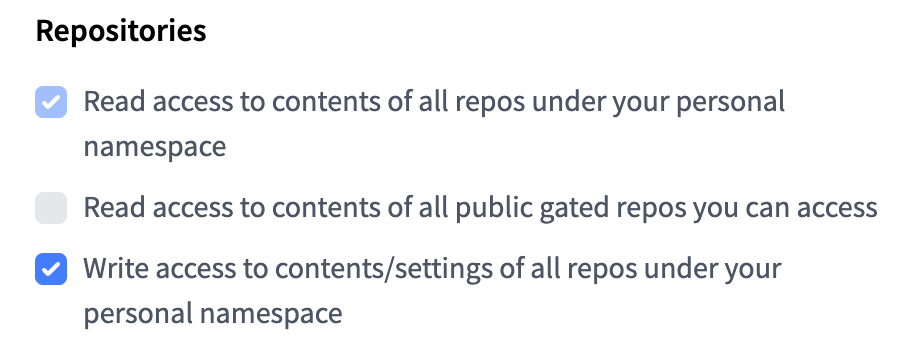

(4) If you forgot to give the above permissions when creating the token then <br>
click on **'Edit permissions'** to add them.

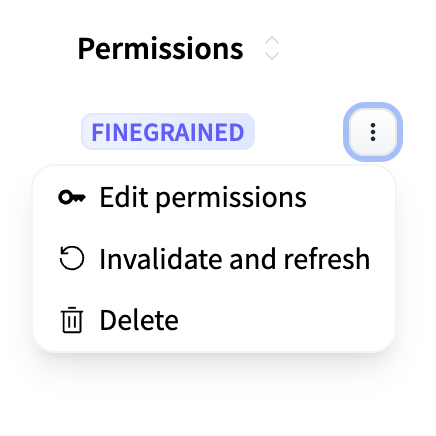

(5) Login using your API key

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import transformers

print(transformers.__version__)

In [ ]:
!pip install datasets

We're going to use the wikitext-2 dataset for model finetuning a LLM

In [ ]:
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

This is an example of what the data looks like. Notice it's just a **raw string**.

In [ ]:
datasets["train"][10]

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(datasets["train"])

We'll also need an LLM starting point. Here we'll use distilgpt2 which is a <br>
reduced size version of GPT-2, a much smaller predecessor to ChatGPT.

In [ ]:
model_checkpoint = "distilgpt2"

We'll also need to **chunk our data strings** into smaller tokens so that it can <br>
be passed to the model like a **time-series**. To do that we'll use a prebuilt <br>
**tokenizer** from `distilgpt2`.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

In [ ]:
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

Notice that now the training dataset is abstracted way into **tokens** matching <br>
where in the **total vocabulary** a particular word is. There's also an **attention** <br>
**mask** value stored which can be used to tell the model to **ignore** a certain <br>
when computing losses and constructing attention maps.

In [ ]:
datasets["train"][1]

In [ ]:
tokenized_datasets["train"][1]

In [ ]:
block_size = tokenizer.model_max_length

In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])


In [ ]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-wikitext2",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=True,
)

If you want to **store model training history** you can create an account on <br>
**Weights and Biases** or wandb at https://wandb.ai/. You can also link this to <br>
your github account just like with the huggingface account. To acces your API <br>
key go to https://wandb.ai/authorize and copy your access token down and put <br>
it into the prompt below.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
)

Perplexity is a **numerical metric** that evaluates how good a model is at <br>
**predicting the next token** in a sequence. We'll compare perplexity before and <br>
after fine tuning on the `wikitext-2` dataset.

In [ ]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

In [ ]:
trainer.train()

In [ ]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

The model's perplexity improved meaning it's now better at doing next token <br>
prediction on the `wikitext-2` dataset. You can also now view your training <br>
model fine tuning training history on wandb.

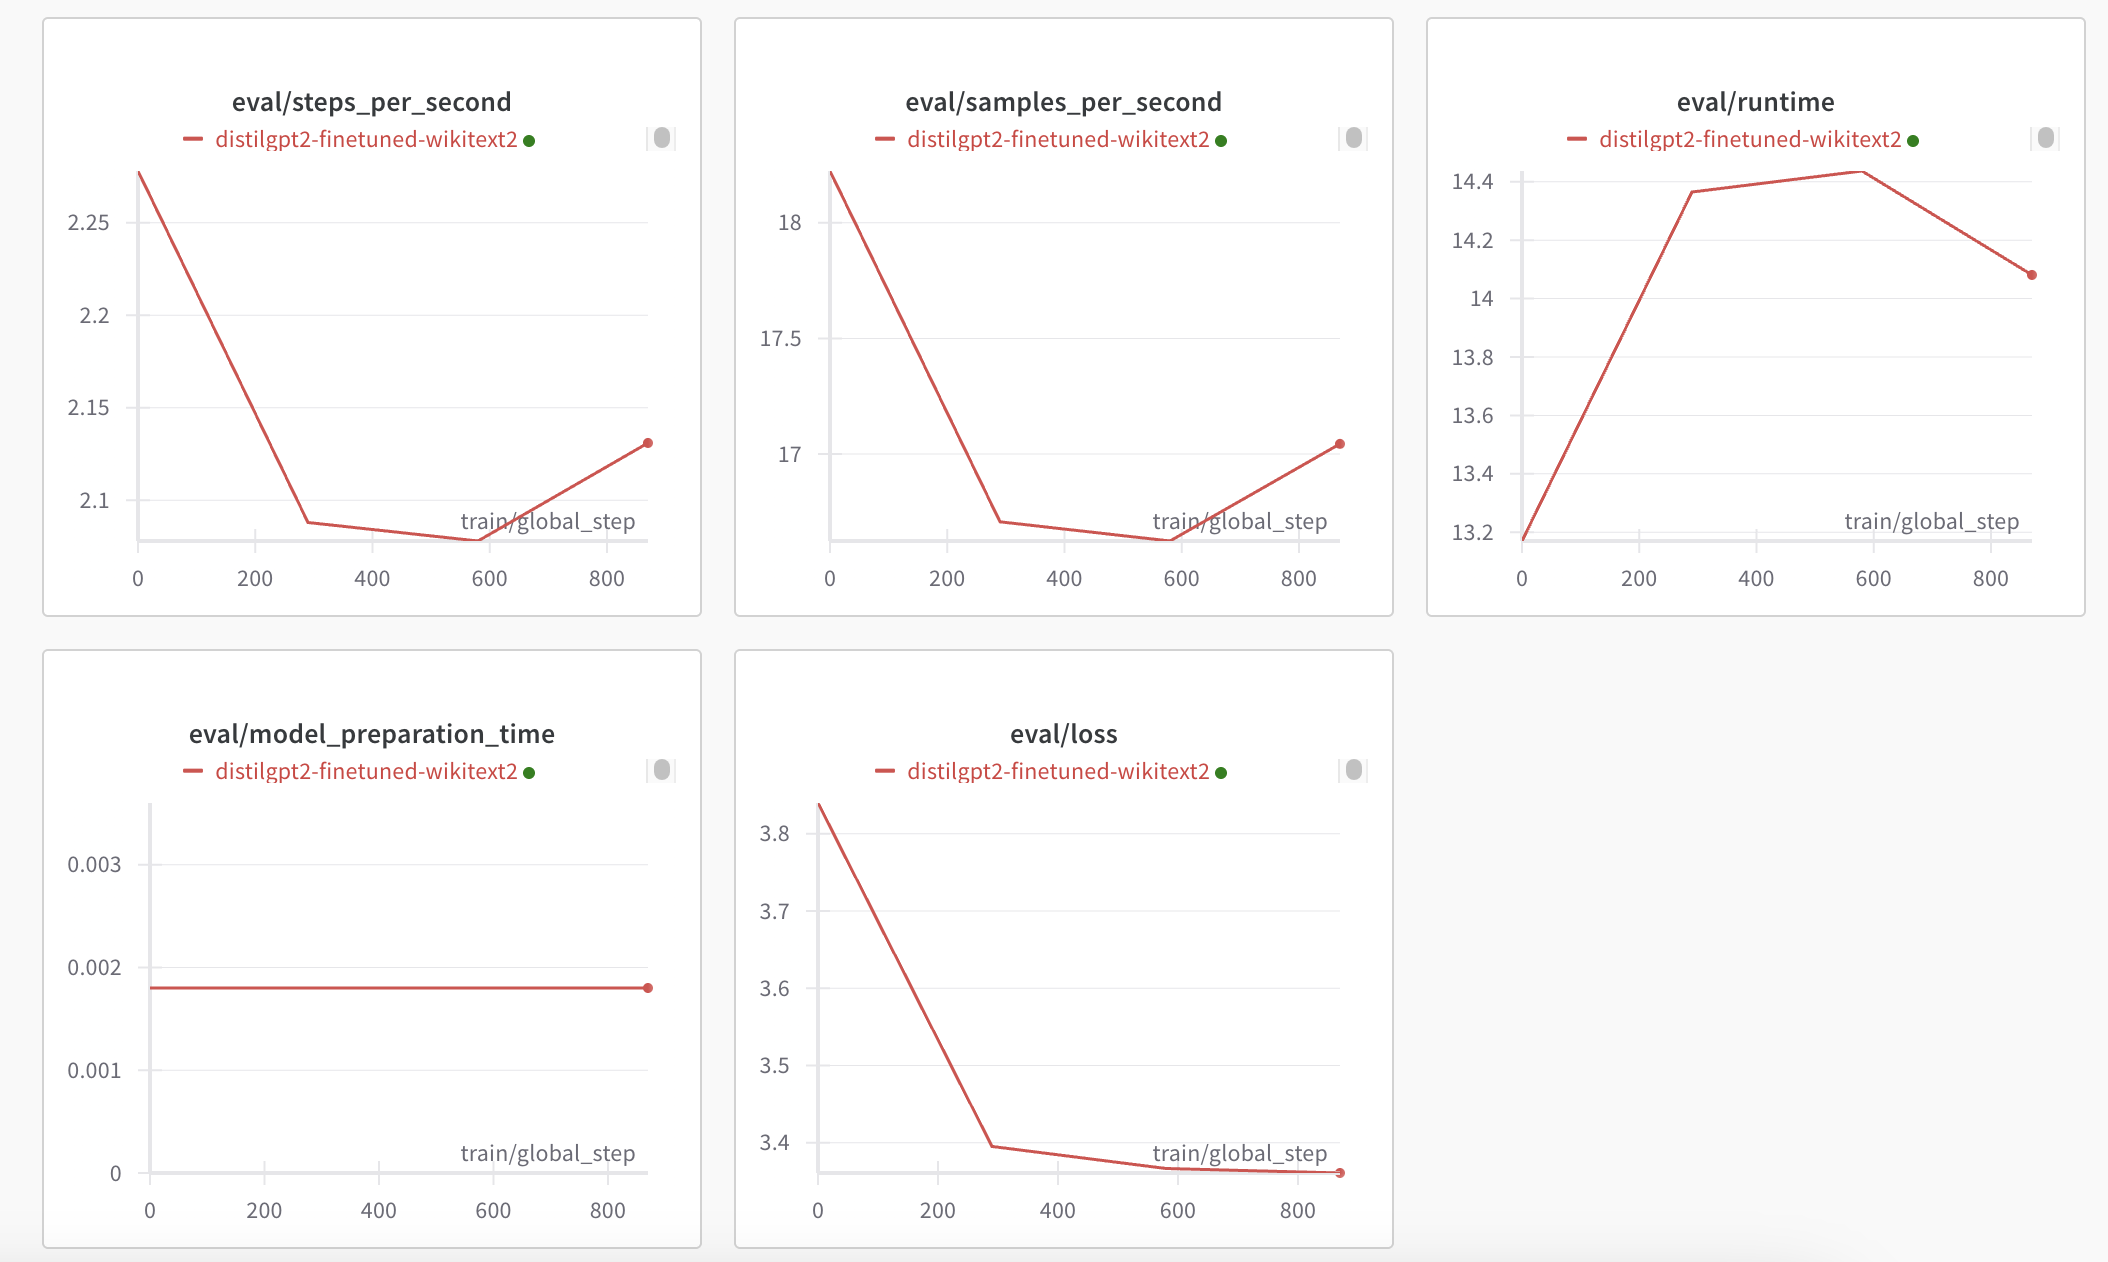

You can also save these models to your `huggingface` account.

In [ ]:
trainer.push_to_hub()